##  搭建一个基于检索的问答系统

##### 完成项目所需的知识点：
##### 1. 字符串操作   2. 文本预处理技术（词过滤，标准化）   3. 文本的表示（tf-idf, word2vec)  4. 文本相似度计算  5. 文本高效检索

##### 此项目需要的数据：
##### 1. dev-v2.0.json: 这个数据包含了问题和答案的pair， 但是以JSON格式存在，需要编写parser来提取出里面的问题和答案。 
##### 2. glove.6B: 这个文件需要从网上下载，下载地址为：https://nlp.stanford.edu/projects/glove/， 请使用d=100的词向量

### Part 1  第一部分： 读取文件，文本的处理。

In [14]:
import json
import nltk
import numpy as np
import scipy.spatial.distance as distance
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# '停用词列表'为所有函数共用(使用nltk停用词)
# nltk.download('stopwords') #下载wordnet语料库
# nltk.download('punkt')
stopWords = stopwords.words("english") #停用词设定为英语
customStopWords = ["when",'what','how','where','the']
stopWords.extend(customStopWords) #添加停用词
#预处理 数据清洗 停用词 小写 去标点
def clean_words(strWords):
    wordList = nltk.word_tokenize(strWords) #分词返回一个分好词的列表
    lemmatizer = WordNetLemmatizer() #词形还原（lemmatization），是把一个词汇还原为一般形式（能表达完整语义）
    filterWords = [lemmatizer.lemmatize(word.lower()) \
                   for word in wordList \
                   if word.isalpha() and word.lower() not in stopWords]
    return filterWords

# 读取数据生成新的字典
def read_corpus():
    filepath = "./data/train-v2.0.json"
    #问题列表
    qList = []
    #问题的关键词列表
    qList_kw = []
    #答案列表
    aList = []
    with open(filepath) as data:
        d = json.load(data)
        for dataSet in d["data"]:
            for par in dataSet["paragraphs"]:
                for qas in par["qas"]:
                    if qas["is_impossible"] == False:
                        strQuestion = qas["question"]
                        qList.append(strQuestion)
                        qList_kw.append(clean_words(strQuestion))
                        aList.append(qas["answers"][0]["text"])
    return qList_kw,qList,aList

qList_kw, qList ,aList = read_corpus()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86189\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\86189\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [17]:
print(qList_kw[0])
print(qList[0])
print(aList[0])

['beyonce', 'start', 'becoming', 'popular']
When did Beyonce start becoming popular?
in the late 1990s


### Part 2 理解数据（可视化分析/统计信息）
对数据的理解是任何AI工作的第一步，需要充分对手上的数据有个更直观的理解。 

TODO: 统计一下在qlist 总共出现了多少个单词？ 总共出现了多少个不同的单词？需要做简单的分词，对于英文我们根据空格来分词即可，

TODO: 在qlist和alist里出现次数最多的TOP 10单词分别是什么？ 
出现最多的十个单词见图中单词   

单词总数:  454147
不同单词数：  30673


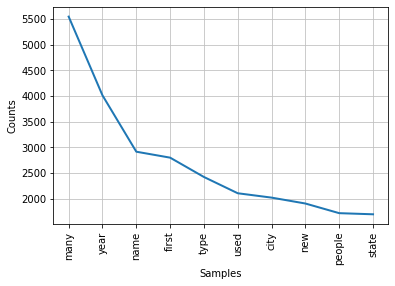

In [19]:
# TODO: 统计一下qlist中每个单词出现的频率，并把这些频率排一下序，然后画成plot. 
#比如总共出现了总共7个不同单词，而且每个单词出现的频率为 4, 5,10,2, 1, 1,1
#       把频率排序之后就可以得到(从大到小) 10, 5, 4, 2, 1, 1, 1. 然后把这7个数plot即可（从大到小）
#       需要使用matplotlib里的plot函数。y轴是词频
def plot_words(wordList):
    fDist = FreqDist(wordList) #构造函数接受一个列表,键为传入构造函数的列表中的不同项，值为项出现的次数
    print("单词总数: ",fDist.N())
    print("不同单词数： ",fDist.B())
    fDist.plot(10)   #plot(n)，绘制出现次数最多的前n项
all_question = " ".join(qList)
qWordList = clean_words(all_question)
plot_words(qWordList)

### 3 文本表示
当我们做完关键的预处理过程之后，就需要把每一个文本转换成向量。

TODO: 把qlist中的每一个问题字符串转换成tf-idf向量, 转换之后的结果存储在X矩阵里。 X的大小是： N* D的矩阵。 这里N是问题的个数（样本个数），
      D是字典库的大小。 
vectorizer =  # 定一个tf-idf的vectorizer
X =   # 结果存放在X矩阵

In [22]:
# TODO: 矩阵X有什么特点？ 计算一下它的稀疏度
def calculate_sparse(qList):
    # 每一个问题转换成tf-idf向量
    vectorizer = TfidfVectorizer(smooth_idf=False, lowercase=True, stop_words=stopWords)
    # 得到的是csr_matrix型矩阵（压缩后的稀疏矩阵）
    vectorizer.fit_transform(qList)
    # 获取词列表
    keywordList = vectorizer.get_feature_names()
    wordNum = len(keywordList)
    # 获取文档总数（问题总数）
    docNum = len(qList)
    #print(docNum)
    # 计算矩阵大小
    matrixSize = wordNum * docNum
    #print(matrixSize)
    # 计算零元素个数
    zeroElementNum = 0
    for question in qList:
        for tmpWord in keywordList:
            if tmpWord not in question:
                zeroElementNum += 1

    # 根据tf-idf公式，若tf为0，那么其tf-idf值必然为零 tf-idf矩阵的稀疏度为
    return zeroElementNum / matrixSize
# sparseDeg = calculate_sparse(qList)
# print (sparseDeg)  # 打印出稀疏度

In [28]:
# # 两个问题之间的相似度(余弦相似度计算)
def calculate_cosSimilarity(input_q,qDict):
    simiVDict = {}
    vectorizer = TfidfVectorizer(smooth_idf = False,lowercase = True, stop_words = stopWords)
    for idx , question in qDict.items():
        tfidf = vectorizer.fit_transform([input_q , question])
        simiValue = ((tfidf * tfidf.T).A)[0,1]
        if simiValue > 0:
            simiVDict[idx] = simiValue
    return simiVDict

### 4 对于用户的输入问题，找到相似度最高的TOP5问题，并把5个潜在的答案做返回

！！！复杂度很高，需要计算很久，请耐心等待

In [29]:

# 给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
# 1. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
# 2. 计算跟每个库里的问题之间的相似度
# 3. 找出相似度最高的top5问题的答案
#  """    
#   top_idxs = []  # top_idxs存放相似度最高的（存在qlist里的）问题的下表     
#   return alist[top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案  

def top5results(input_q):
    qDict = {}
    for idx , question in enumerate(qList):
        qDict[idx] = question
    simiVDict = calculate_cosSimilarity(input_q,qDict)
    d = sorted(simiVDict, key = simiVDict.get,reverse = True)
    print("top5相似-基于余弦相似度")
    for idx in d[:5]:
        print("问题: "+ qList[idx])
        print("答案: "+ aList[idx])

In [30]:
# TODO: 编写几个测试用例，并输出结果
print (top5results("At what age did Frédéric move to Paris?"))

top5相似-基于余弦相似度
问题: At what age did Frédéric move to Paris?
答案: 21
问题: At what age did Chopin move to Paris?
答案: 21
问题: At what age did Frédéric depart from Poland?
答案: 20
问题: Who was Frédéric's trusted adviser while in Paris?
答案: Albert Grzymała
问题: During what month did Frédéric move to Warsaw with his family?
答案: October
None


### 5 利用倒排表优化。 
上面的算法，一个最大的缺点是每一个用户问题都需要跟库里的所有的问题都计算相似度。假设我们库里的问题非常多，这将是效率非常低的方法。 这里面一个方案是通过倒排表的方式，先从库里面找到跟当前的输入类似的问题描述。然后针对于这些candidates问题再做余弦相似度的计算。这样会节省大量的时间。

In [33]:
qList_kw[1]

['area', 'beyonce', 'compete', 'growing']

In [36]:
# TODO: 基于倒排表的优化。在这里，我们可以定义一个类似于hash_map, 比如 inverted_index = {}， 
#然后存放包含每一个关键词的文档出现在了什么位置，
#也就是，通过关键词的搜索首先来判断包含这些关键词的文档（比如出现至少一个），
#然后对于candidates问题做相似度比较。
def invert_idxTable(qList_kw):  # 定一个一个简单的倒排表
    invertTable = {}
    for idx, tmpLst in enumerate(qList_kw):
        for kw in tmpLst:
            if kw in invertTable.keys():
                invertTable[kw].append(idx)
            else:
                invertTable[kw] = [idx]
    return invertTable
# 计算倒排表
invertTable = invert_idxTable(qList_kw) 
#    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
#    1. 利用倒排表来筛选 candidate
#    2. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
#    3. 计算跟每个库里的问题之间的相似度
#    4. 找出相似度最高的top5问题的答案
def filter_questionByInvertTab(inputQuestionKW, questionList, invertTable):
    idxLst = []
    questionDict = {}
    for kw in inputQuestionKW:
        if kw in invertTable.keys():
            idxLst.extend(invertTable[kw])
    idxSet = set(idxLst)
    for idx in idxSet:
        questionDict[idx] = questionList[idx]
    return questionDict

def top5results_invidx(inputQuestion):
    inputQuestionKW = clean_words(inputQuestion)
    filteredQuestionDict = filter_questionByInvertTab(inputQuestionKW, qList, invertTable)
    # 计算相似度
    simiVDict = calculate_cosSimilarity(inputQuestion, filteredQuestionDict)
    d = sorted(simiVDict, key=simiVDict.get, reverse=True)
    #print(d)
    # Top5最相似问题，及它们对应的答案
    print("Top5相似-基于倒排表")
    for idx in d[:5]:
        print("问题： " + qList[idx])
        print("答案： " + aList[idx])

In [37]:
# TODO: 编写几个测试用例，并输出结果
print (top5results_invidx("At what age did Frédéric move to Paris?"))

Top5相似-基于倒排表
问题： At what age did Frédéric move to Paris?
答案： 21
问题： At what age did Chopin move to Paris?
答案： 21
问题： At what age did Frédéric depart from Poland?
答案： 20
问题： Who was Frédéric's trusted adviser while in Paris?
答案： Albert Grzymała
问题： During what month did Frédéric move to Warsaw with his family?
答案： October
None


### 6 基于词向量的文本表示
上面所用到的方法论是基于词袋模型（bag-of-words model）。这样的方法论有两个主要的问题：1. 无法计算词语之间的相似度  2. 稀疏度很高。 在2.7里面我们
讲采用词向量作为文本的表示。词向量方面需要下载： https://nlp.stanford.edu/projects/glove/ （请下载glove.6B.zip），并使用d=100的词向量（100维）。


！！！注意，这个也会运行很久

In [38]:
# TODO
#读取每一个单词的嵌入。这个是 D*H的矩阵，这里的D是词典库的大小， H是词向量的大小。 
#这里面我们给定的每个单词的词向量，那句子向量怎么表达？      
#其中，最简单的方式 句子向量 = 词向量的平均（出现在问句里的）， 
#如果给定的词没有出现在词典库里，则忽略掉这个词。
#    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
#    1. 利用倒排表来筛选 candidate
#    2. 对于用户的输入 input_q，转换成句子向量
#    3. 计算跟每个库里的问题之间的相似度
#    4. 找出相似度最高的top5问题的答案

def top5results_emb(inputQuestion):
    def get_vectorValue(keywordList):
        filePath = "./data/glove.6B/glove.6B.100d.txt"
        vectorValueList = []
        with open(filePath, 'r', encoding='UTF-8') as r:
            for line in r.readlines():
                tmpLst = line.rstrip('\n').split(" ")
                word = tmpLst[0]
                if word in keywordList:
                    vectorValueList.append([float(x) for x in tmpLst[1:]])
        # 按关键词的平均，算句子的向量
        vectorSum = np.sum(vectorValueList, axis=0)
        return vectorSum / len(vectorValueList)
    
    inputQuestionKW = clean_words(inputQuestion)
    # input Question中的keywords
    input_question_vector = get_vectorValue(inputQuestionKW)
    simiVDict = {}
    filteredQuestionDict = filter_questionByInvertTab(inputQuestionKW, qList, invertTable)
    for idx, question in filteredQuestionDict.items():
        # 取得当前问题的Vector值
        filtered_question_vector = get_vectorValue(clean_words(question))
        # 计算与输入问句的cos similarity
        simiVDict[idx] = 1 - distance.cosine(input_question_vector, filtered_question_vector)

    d = sorted(simiVDict, key=simiVDict.get, reverse=True)
    print(d)
    # Top5最相似问题对应的答案
    print("计算Top5相似-基于词向量及倒排表")
    for idx in d[:5]:
        print("问题：" + qList[idx])
        print("答案：" + aList[idx])  

In [39]:
# TODO: 编写几个测试用例，并输出结果
print (top5results_emb("At what age did Frédéric move to Paris?"))
# 我们在验收作业时在后台会建立几个测试用例，来验证返回的准确性。

[772, 782, 1078, 975, 1262, 993, 930, 1045, 980, 793, 995, 844, 1003, 1092, 40307, 860, 45718, 976, 950, 1109, 1000, 1270, 32283, 60772, 1237, 1269, 1046, 1044, 80768, 61817, 47569, 924, 45268, 11415, 1008, 1029, 936, 40067, 61827, 60770, 61855, 977, 61834, 963, 4601, 45163, 4603, 1047, 911, 1001, 962, 912, 83013, 61716, 32285, 61622, 61566, 951, 1015, 847, 61637, 61915, 1077, 1449, 865, 61689, 34678, 757, 84477, 61845, 61899, 61928, 60702, 935, 35102, 1079, 61599, 40293, 61784, 61797, 994, 1027, 32382, 61798, 61871, 83009, 3253, 61582, 61564, 774, 938, 20730, 33755, 39073, 1125, 30114, 61875, 61773, 84473, 845, 39074, 1105, 1041, 1068, 61613, 762, 61676, 61769, 45305, 31402, 61648, 61849, 886, 61706, 61560, 84469, 835, 1094, 889, 61614, 61557, 61792, 44864, 32835, 40308, 61577, 890, 80563, 44855, 32286, 1103, 40309, 61839, 44896, 6718, 818, 75966, 49242, 51460, 61598, 1018, 20931, 61822, 41160, 1143, 61857, 61698, 8121, 61693, 996, 32460, 69133, 39075, 29983, 32278, 53893, 41000, 6190